# Sensor Data Alignment (Using Correlation)

In this exercise you will Learn hwo to align sensor data using the correlation method.

As a first step, let's import the python modules we need.

In [1]:
import numpy as np
import pandas as pd # pip install pandas
from scipy import signal
from matplotlib import pylab as plt

## Sensor Data

Let's assume we have three time series from three sensor data readings (sensor1.csv, sensor2.csv, sensor3.csv).

For the three sensor data readings:
- The sampling frequencies differ.
- The number of samples differ.
- The point in time when measurement started differ.

Let's say the sensors are measuring something similar (e.g. a temperature or a voltage) in the same environment. The code below loads and plots the three time series in the same figure. Notice that the three time series are **miss-aligned** (i.e. the peak in the three time series represents an event that was measured at the same time by the tree sensors, but since sampling frequencies, etc differ, the three times series need to be properly **aligned** with each other).

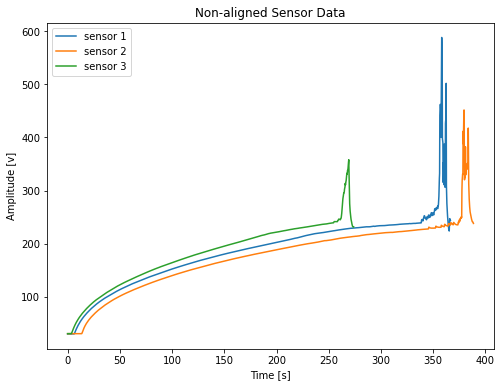

In [2]:
# Load the three time series of sensor data
sensor1 = pd.read_csv('sensor1.csv')
sensor2 = pd.read_csv('sensor2.csv')
sensor3 = pd.read_csv('sensor3.csv')

# Plot the time series in the same figure
plt.figure(figsize=(8,6))
plt.plot(sensor1.time, sensor1.value, label='sensor 1')
plt.plot(sensor2.time, sensor2.value, label='sensor 2')
plt.plot(sensor3.time, sensor3.value, label='sensor 3')
plt.xlabel('Time [s]'), plt.ylabel('Amplitude [v]')
plt.title('Non-aligned Sensor Data')
plt.legend()
plt.show()

## Sensor Data Alignment

We want to fuse the three separate information streams, from the three sensors, into one common information stream. How would be do this? Firstly, we need to **align** the three sensor data streams with each other, so that readings in each of the three streams represent the same point in time.

One method of doing this is to:

1. Calculate the cross-correlation between the data points in two streams,
2. Then shift the data points along the x-axis (time axis) for one of the streams so that they align where they are most correlated.

### 1. Correlation

The correlation function described below, works in exactly the same way as a convolution filter in image processing (but the filter is not mirrored) or in a convolutional neural network layer, as we have seen in earlier workshops. We simply "slide" one of the streams/signals over the other, and at each point calculate a weighted sum of their values.

If `x` and `y` are 1-D arrays and `z = correlate(x, y)`, then for `k = 0, 1, ..., ||x|| + ||y|| - 2`:

$
z_k = \sum_{l=0}^{||x||-1} x_l y_{l-k+N-1}
$

where:
- `||x||` and `||y||` is the length of `x` and `y` respectively
- `N = max(||x||,||y||)`
- `y`<sub>`m`</sub> `= 0` when `m` is outside the range of `y`

#### Example

Let's say we have the two time series (signals) `x` and `y`:
`x = [1,2,3]`  
`y = [4,5,6]`  

To calculate the correlation between these two signals, and since the number of samples in each signal can differ, we need to use zero padding to make the convolution work. In this case, we need to zero-pad `y` with two zeros both at the beginning and the end of the original signal:  
`y = [0,0,4,5,6,0,0]`

We don't need to zero-pad `y` at the beginning of the signal when using Python, since Python's negative indexing will give us what we want (using Python indexing, the two zeros padded at the end of teh singal represent index 3 and 4 AND index -2 and -1 respectively):  
`y = [4,5,6,0,0]`

By interpreting the maths above, our correlation in Python code, for the current example, would look like this:

```
z[0] = x[0]y[2]  + x[1]y[3]  + x[2]y[4] = 1*6 + 2*0 + 3*0 = 6 +  0 +  0 =  6  
z[1] = x[0]y[1]  + x[1]y[2]  + x[2]y[3] = 1*5 + 2*6 + 3*0 = 5 + 12 +  0 = 17  
z[2] = x[0]y[0]  + x[1]y[1]  + x[2]y[2] = 1*4 + 2*5 + 3*6 = 4 + 10 + 18 = 32  
z[3] = x[0]y[-1] + x[1]y[0]  + x[2]y[1] = 1*0 + 2*4 + 3*5 = 0 +  8 + 15 = 23  
z[4] = x[0]y[-2] + x[1]y[-1] + x[2]y[0] = 1*0 + 2*0 + 3*4 = 0 +  0 + 12 = 12  
```

---

Let's try this ourselves:

In [3]:
# Define two simple example signals
x = np.array([1.,2.,3.])
y = np.array([4.,5.,6.])

# Let's write a function that implements the correlation function described above
def correlate_signals(x,y):

    # Let's call the shorter signal x and the longer signal y
    if len(x) > len(y):
        temp = x.copy()
        x = y.copy()
        y = temp

    # From the mathematical exposition above, we know that
    # the resulting signal 'z' will be of a specific length
    # (length=5 in the example, e.g. z = np.array([0.,0.,0.,0.,0.]))
    z = np.zeros(len(x)+len(y)-1)

    # We also need to zero-pad the 'y' signal to make indexing work
    # The 'y' signal needs to be as long as the resulting 'z' signal.
    # Let's call the zero padded signal 'yy'.
    # In the example, the zero-padded signal would look like this:
    # yy = np.array([4.,5.,6.,0.,0.])
    yy = np.zeros(len(x)+len(y)-1)
    yy[0:len(y)] = y

    # Let's also calculate 'K' and 'N' from the mathematical exposition above.
    K = len(x) + len(y) - 2
    N = max(len(x),len(y))

    # Now we can compute the correlation signal 'z'
    for k in range(K+1):
        for l in range(len(x)):
            z[k] += x[l]*yy[l-k+N-1]
    
    # Using the two signals 'x' and 'y' from the example,
    # the double for loop above calculates the following:
    #z[0] = x[0]*yy[2]  + x[1]*yy[3]  + x[2]*yy[4]
    #z[1] = x[0]*yy[1]  + x[1]*yy[2]  + x[2]*yy[3]
    #z[2] = x[0]*yy[0]  + x[1]*yy[1]  + x[2]*yy[2]
    #z[3] = x[0]*yy[-1] + x[1]*yy[0]  + x[2]*yy[1]
    #z[4] = x[0]*yy[-2] + x[1]*yy[-1] + x[2]*yy[0]

    # Return the correlation signal 'z'
    return z

Let's make sure our correlation function works by comparing it with equivalent function in scipy and numpy.

In [4]:
print(correlate_signals(x,y))        # our function
print(signal.correlate(x,y))         # scipy.signal.correlate()
print(np.correlate(x,y,mode='full')) # numpy.correlate()
print(np.convolve(x,y[::-1]))        # numpy.convolve() with y reversed

[ 6. 17. 32. 23. 12.]
[ 6. 17. 32. 23. 12.]
[ 6. 17. 32. 23. 12.]
[ 6. 17. 32. 23. 12.]


### 2. Alignment (Shifting)

Now that we have calculated the correlation between the two signals 'x' and'y', we want to shift the 'y' signal so that the two signals align which each other where they are most correlated. We do this by:
- Finding the `index` of the largest value in the correlated signal.
- Shifting the 'y' signal `index - ||y||` steps along the horizontal (time) axis to align the two singals.

Note, sice the sampling frequencies can differ between the two signals, we multiply the shift `index - ||y||` for signal `y` by the time constant in signal `x`, i.e. `dx`.

In [5]:
def align_signals(signal1, signal2):
    # Calculate the mean delta time (time constant) between samples in signal 1
    dx = np.mean(np.diff(signal1.time.values))

    # Calculate how much to shift signal 2 (notice, we are using the correlation function here)
    shift = (np.argmax(signal.correlate(signal1.value, signal2.value)) - len(signal2.value)) * dx

    # Shift signal 2 along the horizontal (time) axis to align it with signal 1
    aligned_signal2 = signal2.copy()
    aligned_signal2.time += shift

    # Return the aligned signal
    # (i.e. signal 2 aligned with signal 1)
    return aligned_signal2

Now let's revisit our example and align the three signals with each other using the `align_signals` function above.

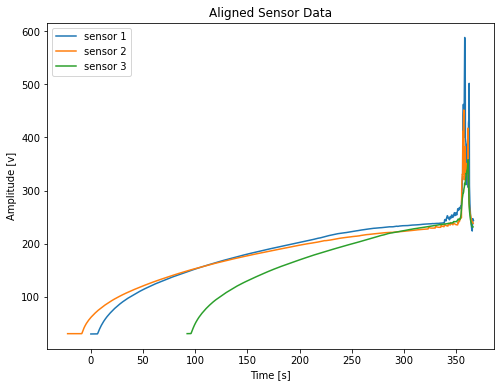

In [6]:
# Load the time series for the three sensors
sensor1 = pd.read_csv('sensor1.csv')
sensor2 = pd.read_csv('sensor2.csv')
sensor3 = pd.read_csv('sensor3.csv')

# Align the second and third time series with the first one
aligned_sensor2 = align_signals(sensor1, sensor2)
aligned_sensor3 = align_signals(sensor1, sensor3)

# Plot the aligned signals
plt.figure(figsize=(8,6))
plt.plot(sensor1.time, sensor1.value, label='sensor 1')
plt.plot(aligned_sensor2.time, aligned_sensor2.value, label='sensor 2')
plt.plot(aligned_sensor3.time, aligned_sensor3.value, label='sensor 3')
plt.xlabel('Time [s]'), plt.ylabel('Amplitude [v]')
plt.title('Aligned Sensor Data')
plt.legend()
plt.show()